In [2]:
from package.las import LASReader
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy import signal
import os

# File, path variables

In [2]:
file = r'file.las'
tops_csv = r'tops.csv'
npd_link = r'file.csv'
sonic_logs = r'sonic_logs'

# Import Formation tops from NPD and Petrel

In [3]:
def importNPD(csv):
    """ 
    Import NPD tops from website (https://www.npd.no/en)
    """
    # load csv file from link or downloaded file
    npdtops = pd.read_csv(csv)
    
    # Rename columns
    columns = list(npdtops.columns)
    rename = ["Well", "MD", "Base", "Surface", "Level", "Parent", "Id", "LithoStrat", "LithoStratParent", "Date", "Sync"]
    rename_cols = dict(zip(columns,rename))
    npdtops.rename(columns=rename_cols, inplace=True)
    
    # Dealing with duplicate (repeated) tops in each well
    #tops[ tops.duplicated(subset=['Well', 'MD'], keep='last')].Surface.str.contains("GP")
    #data[ data.duplicated(subset=['Well', 'MD'], keep='last')].Surface.str.contains("MBR")
    
    # Remove Group level tops
    npdtops = npdtops[ ~npdtops['Surface'].str.contains("GP")]
    # Remove Member level tops
    npdtops = npdtops[ ~npdtops['Surface'].str.contains("MBR")]
    
    # Drop most columns, leaving...?
    npdtops.drop(['Level', 'Parent', 'Id', 'LithoStrat', 'LithoStratParent', 'Date', 'Sync'], axis=1, inplace=True)
    
    return npdtops

npdtops = importNPD(npd_link)


In [4]:
def importPetrel(tops_csv):
    """ 
    Import Petrel tops with time and depth info 
    """
    # Load tops via file
    tops = pd.read_csv(tops_csv)
    
    # Rename columns
    tops.rename(columns={'Well identifier':'Well', 'Z':'TVDSS','TWT auto':'TWT'}, inplace=True)
    # Change TVDSS values to positive down borehole
    tops.TVDSS = tops['TVDSS']*-1

    # Remove rows that have Surface named in del_rows
    del_rows = ['UNDIFFERENTIATED', 'NO FORMAL NAME', 'NO GROUP DEFINED', 'UNDEFINED GP']        
    for i in range(len(del_rows)):
        tops = tops[ tops.Surface != del_rows[i]]

    # Replace misspelled Formation names with correct spelling        
    typos = {'Surface' : {'STﾘ FM':'STØ FM', 'TUBﾅEN FM':'TUBÅEN FM',
                          '?RRET FM':'ØRRET FM', 'R?YE FM':'RØYE FM',
                          '?RN FM':'ØRN FM', 'ISBJ?RN FM':'ISBJØRN FM',
                          'BL坦EROT FM':'BLÆREROT FM'}}        
    tops.replace(typos, inplace=True)
    
    # Deal with duplicate names down each borehole
    #data[ data.duplicated(subset=['Well', 'MD'], keep='last')].Surface.str.contains("GP")
    #data[ data.duplicated(subset=['Well', 'MD'], keep='last')].Surface.str.contains("MBR")
    
    # Remove Group and Member level tops
    tops = tops[ ~tops['Surface'].str.contains("GP")]    
    tops = tops[ ~tops['Surface'].str.contains("MBR")]
    
    """
    tops.drop(['Unnamed: 0', 'TWT picked',  'Geological age', 'TVT', 'TST', 'Interpreter',
            'Observation number', 'Dip angle', 'Dip azimuth', 'Missing', 'Confidence factor', 
            'Used by dep.conv.', 'Used by geo mod', 'Symbol', 'Last edited'], axis=1, inplace=True)
    """

    return tops

petreltops = importPetrel(tops_csv)


In [6]:
tdr_list = []
file_list = open('../sonic_list', 'r') 
for line in file_list: 
    tdr_list.append(line.rstrip())


def correctedTDR(file):
    """
    Imports Petrel TDR (checkshot corrected sonic log) 
    Imports all logs into one DataFrame
    X, Y, Z, TWT picked, MD, Well, Average velocity, Interval velocity
    """
    frame = pd.DataFrame()
    for file in tdr_list:
        df = pd.read_csv(os.path.join(path, file), sep='\s+', skiprows=14, header=None, na_values='-999')
        df = df.rename(columns=({0:'X', 1:'Y', 2:'TVDSS', 3:'TWT', 4:'MD', 5:'Well', 6:'Vavg', 7:'Vint'}))
        df.TVDSS = df['TVDSS']*-1
        df.TWT = df['TWT']*-1
        
        frame = frame.append(df)

    return frame

corrTDR = correctedTDR(tdr_list)

# Merge NPD tops and Petrel tops

In [7]:
def mergeTops(df1, df2):
    """
    Merge NPD tops with Petrel tops
    Merge the two because NPD tops have a base column that is used in the isopach calculation
    """
    df = pd.merge(npdtops, petreltops)

    return df

merge = mergeTops(npdtops, petreltops)
merge.head()

C:\Users\Dunbar\Anaconda3\lib\site-packages\pandas\core\reshape\merge.py:969: UserWarning: You are merging on int and float columns where the float values are not equal to their int representation
  'representation', UserWarning)


,Well,MD,Base,Surface,X,Y,TVDSS,TWT
0,7220/11-3 AR,601,1982,SNADD FM,483739.89,7991462.08,575.97,720.98
1,7220/11-3 AR,2535,2600,UGLE FM,484318.29,7991221.25,2329.03,1766.22
2,7220/11-3 AR,429,575,TORSK FM,483741.51,7991463.79,404.00,531.87
3,7220/11-3 AR,2252,2535,FALK FM,484203.65,7991252.45,2072.32,1663.42
4,7220/11-3 AR,2124,2252,ØRN FM,484152.47,7991269.61,1956.30,1617.93


# Edit merged tops DataFrame.  Add isopach, isochron and interval velocity

In [8]:
def isopach(df):
    """
    # Calculate isopach, df input from mergeTops
    """
    df['Thickness'] = df['Base'] - df['MD']
    
    return df


def wellDict(df):
    """
    create well dictionary as input to isochron
    """
    wells = list(df.Well.unique())
    well_list = []
    for well in wells:
        well = well.replace('/','_')
        well = well.replace('-', '_')
        well = well.replace(" ","")
        well = 'W' + well
        well_list.append(well)

    well_dict = {}
    for i,j in zip(well_list, wells):
        well_dict[i]=j
        
    return well_dict


def isochron(df):
    """
    # df input from mergeTops
    """
    frame = pd.DataFrame()
    well_dict = wellDict(df)
    for k,v in well_dict.items():
        k = df[df['Well']==v].sort_values(by=['MD'])
        k['TWT_d'] = k['TWT'].shift(-1)
        k['Isochron'] = (k['TWT_d'] - k['TWT']) / 2000
        frame = frame.append(k)
        
    return frame


def vint(df):
    """
    Add interval velocity column
    """
    df['Vint'] = df['Thickness'] / df['Isochron']
    
    return df


def midPointDepth(df):
    """
    Add a midpoint depth value
    """
    df['MidPointDepth'] = df['TVDSS'] + (df['Thickness'] / 2)
    
    return df

In [9]:
merge = isopach(merge)

merge = isochron(merge)

merge = vint(merge)

merge = midPointDepth(merge)

plot_tops = merge.drop(['MD', 'Base', 'X', 'Y', 'TWT', 'Thickness', 'TWT_d', 'Isochron', 'Vint'], axis=1)

well = '7120/1-4 S'
tops = plot_tops[plot_tops['Well'] == well]['Surface']
depths = plot_tops[plot_tops['Well'] == well]['TVDSS']

In [10]:
merge[ merge['Surface']=='SNADD FM']

,Well,MD,Base,Surface,X,Y,TVDSS,TWT,Thickness,TWT_d,Isochron,Vint,MidPointDepth
0,7220/11-3 AR,601,1982,SNADD FM,483739.89,7991462.08,575.97,720.98,1381,1552.74,0.415880,3320.669424,1266.47
14,7220/11-1,580,1852,SNADD FM,484390.24,7995617.97,549.99,659.19,1272,1531.82,0.436315,2915.324937,1185.99
16,7220/10-1,2303,2405,SNADD FM,467503.90,7991178.85,2268.99,1794.16,102,NaN,NaN,NaN,2319.99
28,7120/2-3 S,2563,2625,SNADD FM,477676.44,7965806.20,2535.17,1983.12,62,NaN,NaN,NaN,2566.17
38,7120/2-1,613,1933,SNADD FM,481920.18,7987310.83,589.87,708.53,1320,1577.85,0.434660,3036.856394,1249.87
45,7120/1-4 S,733,2274,SNADD FM,471248.15,7982515.38,702.98,797.19,1541,1763.32,0.483065,3190.046888,1473.48
55,7120/1-3,1101,2203,SNADD FM,474680.07,7978470.92,1076.98,1073.31,1102,1728.17,0.327430,3365.604862,1627.98
56,7120/1-1 R2,1106,2285,SNADD FM,475816.14,7980015.31,1080.96,1067.07,1179,1761.48,0.347205,3395.688426,1670.46


## Plotting

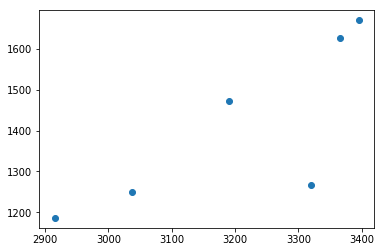

In [13]:
fig, ax = plt.subplots()
ax.scatter(merge[ merge['Surface'] == 'SNADD FM']['Vint'], merge[ merge['Surface'] == 'SNADD FM']['MidPointDepth'])
###

In [ ]:
def velocity_logs(top_depth, bottom_depth):
    
#    logs=data[(data.TVDSS >= top_depth) & (data.TVDSS <= bottom_depth)]
    fig, ax = plt.subplots(nrows=1, ncols=4, figsize=(15,15), sharey=True)
#    fig.suptitle("7321/4-1 T2", fontsize=22)
    fig.subplots_adjust(top=0.9,wspace=0.1)
    
    #General setting for all axis
    for axes in ax:
        axes.set_ylim (top_depth,bottom_depth)
        axes.invert_yaxis()
        axes.yaxis.grid(True)
        axes.get_xaxis().set_visible(False)
        for (i,j) in zip(depths,tops):
            if ((i>=top_depth) and (i<=bottom_depth)):
                axes.axhline(y=i, linewidth=0.5, color='black')
                axes.text(0.1, i ,j, horizontalalignment='center',verticalalignment='center')


###########################################################

    # 1st track: DT
    
    ax01=ax[0].twiny()
    ax01.grid(True)
    ax01.set_xlim(1000,0)
    ax01.spines['top'].set_position(('outward',0))
    ax01.set_xlabel('Vint[m/s]')
    ax01.plot(data.data['AC'], data.data['TVDSS'], label='DT[usec/m]', color='blue')
    ax01.set_xlabel('DT[usec/m]', color='blue')    
    ax01.tick_params(axis='x', colors='blue')

    # 2nd track: Velocity from sonic
    
    ax02=ax[1].twiny()
    ax02.grid(True)
    ax02.set_xlim(0,7000)
    ax02.spines['top'].set_position(('outward',0))
    ax02.set_xlabel('TDR (corrected) [m/s]')
    ax02.plot(corrTDR[ corrTDR['Well']=='7120/1-3']['Vint'], corrTDR[ corrTDR['Well']=='7120/1-3']['TVDSS'], label='TDR (corr) [m/s]', color='blue')
    ax02.set_xlabel('TDR (corr) [m/s]', color='blue')    
    ax02.tick_params(axis='x', colors='blue')
    
    # 3rd track: Checkshot
    
    ax03=ax[2].twiny()
    ax03.grid(True)
    ax03.set_xlim(0,7000)
    ax03.spines['top'].set_position(('outward',0))
    ax03.set_xlabel('Vint[m/s]')
    ax03.scatter(merge[ merge['Well']=='7120/1-4 S']['Vint'], merge[ merge['Well']=='7120/1-4 S']['MidPointDepth'], label='Vint[m/s]', color='green')
    ax03.set_xlabel('Vint[m/s]', color='green')    
    ax03.tick_params(axis='x', colors='green')

    # 4th track: TDR calibrated synthetic interval velocity
    
    ax04=ax[3].twiny()
    ax04.grid(True)
    ax04.set_xlim(1000,0)
    ax04.spines['top'].set_position(('outward',0))
    ax04.set_xlabel('Median [m/s]')
    ax04.plot(sonicMedFilt, data.data['TVDSS'], label='Median [m/s]', color='red')
    ax04.set_xlabel('Median [m/s]', color='orange')    
    ax04.tick_params(axis='x', colors='orange')
    

In [ ]:
velocity_logs(0,2500)

In [ ]:
file1 = r'./sonic_logs/7120_1-1R2_TDR_CalTDR_DTvp-RHOB_CSDea'
data1 = pd.read_csv(file1, sep='\s+', skiprows=14, header=None, na_values='-999')
data1 = data1.rename(columns=({0:'X', 1:'Y', 2:'TVDSS', 3:'TWT', 4:'MD', 5:'Well', 6:'Vavg', 7:'Vint'}))
data1.TVDSS = data1['TVDSS']*-1
data1.TWT = data1['TWT']*-1

file2 = r'./sonic_logs/7120_1-3_TDR_CalTDR_DTvp_CS-DEA_Corr1400-1900ms_BSp6ms'
data2 = pd.read_csv(file2, sep='\s+', skiprows=14, header=None, na_values='-999')
data2 = data2.rename(columns=({0:'X', 1:'Y', 2:'TVDSS', 3:'TWT', 4:'MD', 5:'Well', 6:'Vavg', 7:'Vint'}))
data2.TVDSS = data2['TVDSS']*-1
data2.TWT = data2['TWT']*-1

file3 = r'./sonic_logs/7120_1-4S_TDR_CalTDR_DTvp_DEN_CSDea_BS0ms'
data3 = pd.read_csv(file3, sep='\s+', skiprows=14, header=None, na_values='-999')
data3 = data3.rename(columns=({0:'X', 1:'Y', 2:'TVDSS', 3:'TWT', 4:'MD', 5:'Well', 6:'Vavg', 7:'Vint'}))
data3.TVDSS = data3['TVDSS']*-1
data3.TWT = data3['TWT']*-1

file4 = r'./sonic_logs/7120_1-5_TDR_CalTDR_AC-DEN_CSDiskos'
data4 = pd.read_csv(file4, sep='\s+', skiprows=14, header=None, na_values='-999')
data4 = data4.rename(columns=({0:'X', 1:'Y', 2:'TVDSS', 3:'TWT', 4:'MD', 5:'Well', 6:'Vavg', 7:'Vint'}))
data4.TVDSS = data4['TVDSS']*-1
data4.TWT = data4['TWT']*-1

file5 = r'./sonic_logs/7120_2-1_TDR_CalTDR_DTvp-RHOB_BS0ms'
data5 = pd.read_csv(file5, sep='\s+', skiprows=14, header=None, na_values='-999')
data5 = data5.rename(columns=({0:'X', 1:'Y', 2:'TVDSS', 3:'TWT', 4:'MD', 5:'Well', 6:'Vavg', 7:'Vint'}))
data5.TVDSS = data5['TVDSS']*-1
data5.TWT = data5['TWT']*-1

file6 = r'./sonic_logs/7120_2-2_TDR_CalTDR_LN17_EW'
data6 = pd.read_csv(file6, sep='\s+', skiprows=14, header=None, na_values='-999')
data6 = data6.rename(columns=({0:'X', 1:'Y', 2:'TVDSS', 3:'TWT', 4:'MD', 5:'Well', 6:'Vavg', 7:'Vint'}))
data6.TVDSS = data6['TVDSS']*-1
data6.TWT = data6['TWT']*-1

file7 = r'./sonic_logs/7120_2-3S_TDR_CalTDR_EW1500-2006_BS0ms'
data7 = pd.read_csv(file7, sep='\s+', skiprows=14, header=None, na_values='-999')
data7 = data7.rename(columns=({0:'X', 1:'Y', 2:'TVDSS', 3:'TWT', 4:'MD', 5:'Well', 6:'Vavg', 7:'Vint'}))
data7.TVDSS = data7['TVDSS']*-1
data7.TWT = data7['TWT']*-1

file8 = r'./sonic_logs/7219_12-1_TDR_CalTDR_AC_CSDiskos'
data8 = pd.read_csv(file8, sep='\s+', skiprows=14, header=None, na_values='-999')
data8 = data8.rename(columns=({0:'X', 1:'Y', 2:'TVDSS', 3:'TWT', 4:'MD', 5:'Well', 6:'Vavg', 7:'Vint'}))
data8.TVDSS = data8['TVDSS']*-1
data8.TWT = data8['TWT']*-1

file9 = r'./sonic_logs/7219_12-3S_TDR_CalTDR'
data9 = pd.read_csv(file9, sep='\s+', skiprows=14, header=None, na_values='-999')
data9 = data9.rename(columns=({0:'X', 1:'Y', 2:'TVDSS', 3:'TWT', 4:'MD', 5:'Well', 6:'Vavg', 7:'Vint'}))
data9.TVDSS = data9['TVDSS']*-1
data9.TWT = data9['TWT']*-1

file10 = r'./sonic_logs/7220_10-1_TDR_CalTDR_AC_CSDea_EW'
data10 = pd.read_csv(file10, sep='\s+', skiprows=14, header=None, na_values='-999')
data10 = data10.rename(columns=({0:'X', 1:'Y', 2:'TVDSS', 3:'TWT', 4:'MD', 5:'Well', 6:'Vavg', 7:'Vint'}))
data10.TVDSS = data10['TVDSS']*-1
data10.TWT = data10['TWT']*-1

file11 = r'./sonic_logs/7220_11-1_TDR_CalTDR_AC-RHOB_CSDea'
data11 = pd.read_csv(file11, sep='\s+', skiprows=14, header=None, na_values='-999')
data11 = data11.rename(columns=({0:'X', 1:'Y', 2:'TVDSS', 3:'TWT', 4:'MD', 5:'Well', 6:'Vavg', 7:'Vint'}))
data11.TVDSS = data11['TVDSS']*-1
data11.TWT = data11['TWT']*-1

file12 = r'./sonic_logs/7220_11-2_TDR_CalTDR_AC-DEN_LN17_CS'
data12 = pd.read_csv(file12, sep='\s+', skiprows=14, header=None, na_values='-999')
data12 = data12.rename(columns=({0:'X', 1:'Y', 2:'TVDSS', 3:'TWT', 4:'MD', 5:'Well', 6:'Vavg', 7:'Vint'}))
data12.TVDSS = data12['TVDSS']*-1
data12.TWT = data12['TWT']*-1

file13 = r'./sonic_logs/7220_11-3AR_TDR_CalTDR_AC-DEN_LN17_BS0ms'
data13 = pd.read_csv(file13, sep='\s+', skiprows=14, header=None, na_values='-999')
data13 = data13.rename(columns=({0:'X', 1:'Y', 2:'TVDSS', 3:'TWT', 4:'MD', 5:'Well', 6:'Vavg', 7:'Vint'}))
data13.TVDSS = data13['TVDSS']*-1
data13.TWT = data13['TWT']*-1

file14 = r'./sonic_logs/7220_11-4_TDR_CalTDR_AC-DEN_LN17_CSDea'
data14 = pd.read_csv(file14, sep='\s+', skiprows=14, header=None, na_values='-999')
data14 = data14.rename(columns=({0:'X', 1:'Y', 2:'TVDSS', 3:'TWT', 4:'MD', 5:'Well', 6:'Vavg', 7:'Vint'}))
data14.TVDSS = data14['TVDSS']*-1
data14.TWT = data14['TWT']*-1

In [ ]:
colors = ["red", "blue", "green", "orange", "black", "purple", "pink", "teal"]

def velocity_logs(top_depth, bottom_depth):
    
    logs=data1[(data1.TVDSS >= top_depth) & (data1.TVDSS <= bottom_depth)]
    fig, ax = plt.subplots(nrows=1, ncols=8, figsize=(15,15), sharey=True)
    fig.suptitle("Alta", fontsize=22)
    fig.subplots_adjust(top=0.9,wspace=0.1)

#General setting for all axis
    for axes in ax:
        axes.set_ylim (top_depth,bottom_depth)
        axes.invert_yaxis()
        axes.yaxis.grid(True)
        axes.get_xaxis().set_visible(False)
#        for (i,j) in zip(W7120_1_1_R2['TVDSS'], W7120_1_1_R2['Surface']):
#            if ((i>=top_depth) and (i<=bottom_depth)):
#                axes.axhline(y=i, linewidth=0.5, color='black')
#                axes.text(0.1, i ,j, horizontalalignment='center',verticalalignment='center')



    ax[0]=ax[0].twiny()
    ax[0].grid(True)
    ax[0].set_xlim(0,7000)
    ax[0].spines['top'].set_position(('outward',0))
    ax[0].set_xlabel('Vint[m/s]')
    ax[0].plot(data1.Vint, data1.TVDSS, label='Vint[m/s]', color=colors[0])
    ax[0].set_xlabel('Vint[m/s]', color=colors[0])    
    ax[0].tick_params(axis='x', colors=colors[0])
    ax[0].set_xlabel('Vavg[m/s]')
    ax[0].plot(data1.Vavg, data1.TVDSS, label='Vavg[m/s]', color=colors[1])
    ax[0].set_xlabel('Vavg[m/s]', color=colors[1])

    ax[1]=ax[1].twiny()
    ax[1].grid(True)
    ax[1].set_xlim(0,7000)
    ax[1].spines['top'].set_position(('outward',0))
    ax[1].set_xlabel('Vint[m/s]')
    ax[1].plot(data2.Vint, data2.TVDSS, label='Vint[m/s]', color=colors[0])
    ax[1].set_xlabel('Vint[m/s]', color=colors[0])    
    ax[1].tick_params(axis='x', colors=colors[0])
    ax[1].set_xlabel('Vavg[m/s]')
    ax[1].plot(data2.Vavg, data2.TVDSS, label='Vavg[m/s]', color=colors[1])
    ax[1].set_xlabel('Vavg[m/s]', color=colors[1])
    
    ax[2]=ax[2].twiny()
    ax[2].grid(True)
    ax[2].set_xlim(0,7000)
    ax[2].spines['top'].set_position(('outward',0))
    ax[2].set_xlabel('Vint[m/s]')
    ax[2].plot(data3.Vint, data3.TVDSS, label='Vint[m/s]', color=colors[0])
    ax[2].set_xlabel('Vint[m/s]', color=colors[0])    
    ax[2].tick_params(axis='x', colors=colors[0])
    ax[2].set_xlabel('Vavg[m/s]')
    ax[2].plot(data3.Vavg, data3.TVDSS, label='Vavg[m/s]', color=colors[1])
    ax[2].set_xlabel('Vavg[m/s]', color=colors[1])

    ax[3]=ax[3].twiny()
    ax[3].grid(True)
    ax[3].set_xlim(0,7000)
    ax[3].spines['top'].set_position(('outward',0))
    ax[3].set_xlabel('Vint[m/s]')
    ax[3].plot(data4.Vint, data4.TVDSS, label='Vint[m/s]', color=colors[0])
    ax[3].set_xlabel('Vint[m/s]', color=colors[0])    
    ax[3].tick_params(axis='x', colors=colors[0])
    ax[3].set_xlabel('Vavg[m/s]')
    ax[3].plot(data4.Vavg, data4.TVDSS, label='Vavg[m/s]', color=colors[1])
    ax[3].set_xlabel('Vavg[m/s]', color=colors[1])

    ax[4]=ax[4].twiny()
    ax[4].grid(True)
    ax[4].set_xlim(0,7000)
    ax[4].spines['top'].set_position(('outward',0))
    ax[4].set_xlabel('Vint[m/s]')
    ax[4].plot(data5.Vint, data5.TVDSS, label='Vint[m/s]', color=colors[0])
    ax[4].set_xlabel('Vint[m/s]', color=colors[0])    
    ax[4].tick_params(axis='x', colors=colors[0])
    ax[4].set_xlabel('Vavg[m/s]')
    ax[4].plot(data5.Vavg, data5.TVDSS, label='Vavg[m/s]', color=colors[1])
    ax[4].set_xlabel('Vavg[m/s]', color=colors[1])

    ax[5]=ax[5].twiny()
    ax[5].grid(True)
    ax[5].set_xlim(0,7000)
    ax[5].spines['top'].set_position(('outward',0))
    ax[5].set_xlabel('Vint[m/s]')
    ax[5].plot(data6.Vint, data6.TVDSS, label='Vint[m/s]', color=colors[0])
    ax[5].set_xlabel('Vint[m/s]', color=colors[0])    
    ax[5].tick_params(axis='x', colors=colors[0])
    ax[5].set_xlabel('Vavg[m/s]')
    ax[5].plot(data6.Vavg, data6.TVDSS, label='Vavg[m/s]', color=colors[1])
    ax[5].set_xlabel('Vavg[m/s]', color=colors[1])

    ax[6]=ax[6].twiny()
    ax[6].grid(True)
    ax[6].set_xlim(0,7000)
    ax[6].spines['top'].set_position(('outward',0))
    ax[6].set_xlabel('Vint[m/s]')
    ax[6].plot(data7.Vint, data7.TVDSS, label='Vint[m/s]', color=colors[0])
    ax[6].set_xlabel('Vint[m/s]', color=colors[0])    
    ax[6].tick_params(axis='x', colors=colors[0])
    ax[6].set_xlabel('Vavg[m/s]')
    ax[6].plot(data7.Vavg, data7.TVDSS, label='Vavg[m/s]', color=colors[1])
    ax[6].set_xlabel('Vavg[m/s]', color=colors[1])

    ax[7]=ax[7].twiny()
    ax[7].grid(True)
    ax[7].set_xlim(0,7000)
    ax[7].spines['top'].set_position(('outward',0))
    ax[7].set_xlabel('Vint[m/s]')
    ax[7].plot(data8.Vint, data8.TVDSS, label='Vint[m/s]', color=colors[0])
    ax[7].set_xlabel('Vint[m/s]', color=colors[0])    
    ax[7].tick_params(axis='x', colors=colors[0])
    ax[7].set_xlabel('Vavg[m/s]')
    ax[7].plot(data8.Vavg, data8.TVDSS, label='Vavg[m/s]', color=colors[1])
    ax[7].set_xlabel('Vavg[m/s]', color=colors[1])

